# Titanic : Machine Learning from Disaster

In this notebook, we are going to create an algorithm which will predict  if a passenger of the titanic survived or not. This algorithm will learn from train dataset and then it will predict if each passenger of the test dataset survived. 

The plan to do that is the following one :

1. Exploration of data
2. Features engineering
3. Cross validation testing of the model
4. Prediction on test data & submission on kaggle

## Imports and useful functions

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
#path of datasets
path_train = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/train.csv')
path_test = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/test.csv')

def display_confusion_matrix(sample_test, prediction, score=None):
    cm = metrics.confusion_matrix(sample_test, prediction)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        all_sample_title = 'Accuracy Score: {0}'.format(score)
        plt.title(all_sample_title, size = 15)
    print(metrics.classification_report(sample_test, prediction))
    
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz"""
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Function with standardize a dataframe by setting mean to 0 and var to 1
def standardize(df, target=None, categorical=None):
    
    standardize_df = df
    
    if target:
        target_serie = standardize_df[target] # Separating out the target before standardizing
        standardize_df = standardize_df.drop([target],  axis=1)
    
    if categorical:
        cat_serie = standardize_df[categorical] # Separating out categorical feature(s) before standardizing
        standardize_df = standardize_df.drop([categorical],  axis=1)

    # Standardizing the features
    scaled_values = StandardScaler().fit_transform(standardize_df.values)
    standardize_df = pd.DataFrame(scaled_values, index=standardize_df.index, columns=standardize_df.columns)
    
    if target:
        standardize_df = standardize_df.join(target_serie)
        
    if categorical:
        standardize_df = standardize_df.join(cat_serie)
    
    return standardize_df

## 1. Data exploration

In [6]:
#create dataframe for training dataset and print ten first rows as preview
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Compute some basical statistics on the dataset
train_df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [9]:
draw_missing_data_table(train_df_raw)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


There is 77% of missing data in the cabin column, it's way too much for this column to be exploitable, so we'll remove it from the dataframe. For the age, we will either interpolate missing values or we will fill it with the median. There is only two missing values for the embarked column, let's replace them by the most recurrent value of Embarqued variable :

In [10]:
train_df_raw['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

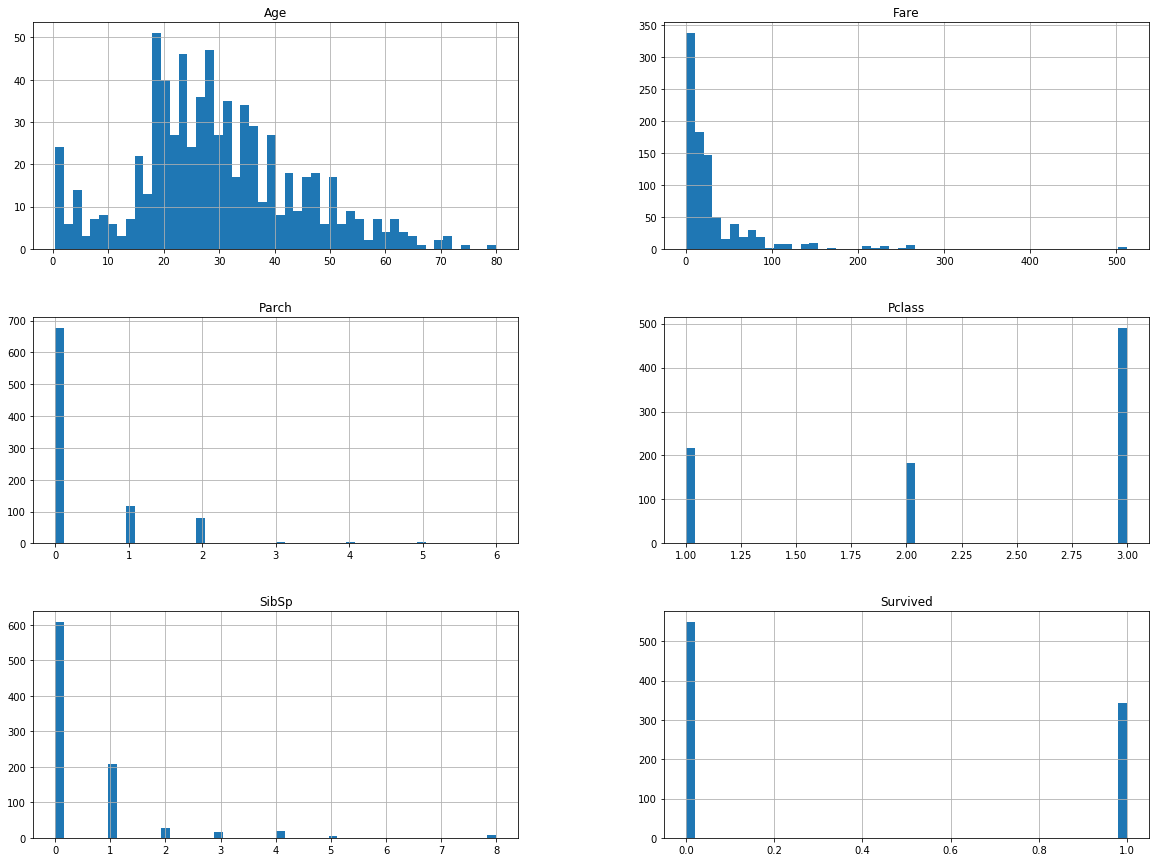

In [11]:
# Let's plot some histograms to have a previzualisation of some of the data ...
train_df_raw.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

With this first exploration, we can see that :

* Only aproximately 35% of passengers survived ...
* More than the half of passengers are in the lowest class (pclass = 3)
* Most of the fare tickets are below 50
* Majority of passengers are alone (sibsp and parch)

## 2. Features engineering

In [12]:
def preprocess_data(df):
    
    processed_df = df
    
    # Drop useless columns
    processed_df = processed_df.drop(['PassengerId'], 1)
    
    # Deal with missing values
    processed_df['Embarked'].fillna('S', inplace=True)
    processed_df['Age'].fillna(processed_df['Age'].mean(), inplace=True)
    processed_df['Fare'] = processed_df['Fare'].interpolate()
    processed_df['Cabin'].fillna('U0', inplace=True)
    
    # feature engineering on columns
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in train_df_raw['Name']), index=train_df_raw.index)
    processed_df['Title'] = processed_df['Title'].replace('the Countess', 'Mrs')
    processed_df['Title'] = processed_df['Title'].replace('Lady', 'Mrs')
    processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')
    processed_df['Title'] = processed_df['Title'].replace('Mlle', 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Don', 'Mr')
    processed_df['Title'] = processed_df['Title'].replace('Col', 'Master')
    processed_df['Title'] = processed_df['Title'].replace('Major', 'Master')
    processed_df['Title'] = processed_df['Title'].replace('Sir', 'Mr')
    processed_df['Title'] = processed_df['Title'].replace('Capt', 'Mr')
    processed_df['Title'] = processed_df['Title'].replace('Ms', 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Jonkheer', 'Mr')
    processed_df = processed_df.drop(['Name'], 1)
    processed_df = pd.get_dummies(processed_df, columns=['Title'])
    processed_df = pd.get_dummies(processed_df, columns=['Sex'])
    processed_df = pd.get_dummies(processed_df, columns=['Embarked'])
    processed_df['Familly'] = processed_df['SibSp'] + processed_df['Parch']
    
    # Modify the ticket column to keep only the ticket number
    ticket_numbers = list()
    for ticket in processed_df['Ticket']:
        try:
            ticket_numbers.append(int(ticket))
        except ValueError:
            splitted = ticket.split(' ')
            if len(splitted) == 1:
                ticket_numbers.append(0)
            else:
                ticket_numbers.append(int(splitted[len(splitted)-1]))
    processed_df['Ticket'] = pd.Series(ticket_numbers, index=df.index)
    
    #Creation of a deck column corresponding to the letter contained in the cabin value
    processed_df['Deck'] = pd.Series(([cab[:1] for cab in processed_df['Cabin']]), index=processed_df.index)
    processed_df['Deck'] = processed_df['Deck'].replace('T', 'U')
    processed_df = pd.get_dummies(processed_df, columns=['Deck'])

    #cabin_numbers = list()
    #for cab3 in df['Cabin']:
    #    if len(cab3) != 1:
    #        cabin_numbers.append(int(cab3[1:].strip()) if len(cab3[1:]) <= 3 else int(cab3[len(cab3)-2:].strip()))
    #    else:
    #        cabin_numbers.append(0)
    # df['Cabin'] = pd.Series(cabin_numbers, index=df.index)
    
    processed_df = processed_df.drop(['Cabin'], 1)    
    
    return processed_df

## 3. Build neural network and try it !

In [15]:
# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
train_df = train_df_raw.copy()
X = train_df.drop(['Survived'], 1)
y = train_df['Survived']

# Split dataset for prediction
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)
X_train = standardize(X_train)
X_test = standardize(X_test)

X_train.head()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Title_Dr,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Familly,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
331,-1.614136,1.232263,-0.470722,-0.479342,-0.285726,-0.078684,-0.084096,-0.234126,-0.507888,0.833809,...,0.592489,-0.554666,-0.119352,-0.237444,3.562627,-0.165581,-0.186772,-0.130931,-0.065049,-1.872519
733,-0.400551,-0.500482,-0.470722,-0.479342,-0.413424,-0.377145,-0.084096,-0.234126,-0.507888,0.833809,...,0.592489,-0.554666,-0.119352,-0.237444,-0.280692,-0.165581,-0.186772,-0.130931,-0.065049,0.534040
382,0.813034,0.192616,-0.470722,-0.479342,4.223884,-0.474867,-0.084096,-0.234126,-0.507888,0.833809,...,0.592489,-0.554666,-0.119352,-0.237444,-0.280692,-0.165581,-0.186772,-0.130931,-0.065049,0.534040
704,0.813034,-0.269449,0.379923,-0.479342,0.071907,-0.476230,-0.084096,-0.234126,-0.507888,0.833809,...,0.592489,0.040096,-0.119352,-0.237444,-0.280692,-0.165581,-0.186772,-0.130931,-0.065049,0.534040
813,0.813034,-1.809667,2.931860,2.048742,0.067466,-0.025249,-0.084096,-0.234126,1.968937,-1.199315,...,0.592489,3.013909,-0.119352,-0.237444,-0.280692,-0.165581,-0.186772,-0.130931,-0.065049,0.534040


In [18]:
def build_ann():
    # Initializing our ANN
    ann = Sequential()
    # Adding the input layer and the first hidden layer of our ANN with dropout
    ann.add(Dense(units=20, kernel_initializer='uniform', activation='relu', input_shape = (26,)))
    ann.add(Dropout(p=0.5)) 
    ann.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
    ann.add(Dropout(p=0.5))
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    # Compilling the ANN
    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [29]:
classifier = build_ann()
# Training the ANN
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
712/712 [==============================] - 1s 1ms/step - loss: 0.6860 - acc: 0.6545
Epoch 2/100
712/712 [==============================] - 0s 261us/step - loss: 0.5834 - acc: 0.7978
Epoch 3/100
712/712 [==============================] - 0s 333us/step - loss: 0.4538 - acc: 0.8146
Epoch 4/100
712/712 [==============================] - 0s 272us/step - loss: 0.4219 - acc: 0.8329
Epoch 5/100
712/712 [==============================] - 0s 242us/step - loss: 0.4193 - acc: 0.8399
Epoch 6/100
712/712 [==============================] - 0s 247us/step - loss: 0.4082 - acc: 0.8385
Epoch 7/100
712/712 [==============================] - 0s 287us/step - loss: 0.4017 - acc: 0.8427
Epoch 8/100
712/712 [==============================] - 0s 328us/step - loss: 0.3973 - acc: 0.8413
Epoch 9/100
712/712 [==============================] - 0s 245us/step - loss: 0.3917 - acc: 0.8511
Epoch 10/100
712/712 [==============================] - 0s 237us/step - loss: 0.3883 - acc: 0.8497
Epoch 11/100
712/712 

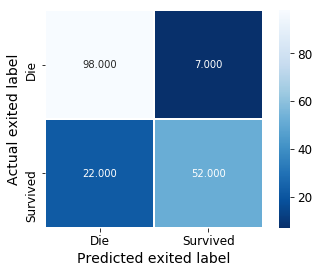

In [30]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5) # convert probabilities to binary output

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig = plt.subplot()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual exited label')
plt.xlabel('Predicted exited label')
fig.xaxis.set_ticklabels(['Die', 'Survived'])
fig.yaxis.set_ticklabels(['Die', 'Survived']);
plt.show()

## 4. Evaluating model with cross validation

In [33]:
classifier = KerasClassifier(build_fn=build_ann, batch_size=10, epochs=100, verbose=0)
accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, n_jobs=1)

In [34]:
mean = accuracies.mean()
variance = accuracies.std()
print('Mean accuracy:', mean, '\nVariance:', variance)

Mean accuracy: 0.827308290028516 
Variance: 0.04471317242596309


Over many trainings, our model performed almost 83% on unseen data !

## 5. Tune the model to increase accuracy

In [16]:
def build_tuned_ann(optimizer):
    # Initializing our ANN
    ann = Sequential()
    # Adding the input layer and the first hidden layer of our ANN with dropout
    ann.add(Dense(units=20, kernel_initializer='uniform', activation='relu', input_shape = (26,)))
    ann.add(Dropout(p=0.5)) 
    ann.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
    ann.add(Dropout(p=0.5))
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    # Compilling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return ann

classifier = KerasClassifier(build_fn=build_tuned_ann, verbose=0)

parameters = {
    'batch_size' : [10, 25, 38],
    'epochs' : [100, 200, 300],
    'optimizer' : ['adam', 'rmsprop']
}

grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print('Best accuracy:', best_accuracy, '\nBest parameters:', best_params)

Best accuracy: 0.8469101123595506 
Best parameters: {'batch_size': 10, 'epochs': 200, 'optimizer': 'adam'}


## 5. Apply on test dataset and submit on kaggle 

In [20]:
test_df_raw = pd.read_csv(path_test)
test_df = test_df_raw.copy()
X2_test = preprocess_data(test_df)
X2_test = standardize(X2_test)
X2 = standardize(preprocess_data(X))

In [24]:
# Create and train model on train data sample
classifier2 = build_ann()
classifier2.fit(X2, y, batch_size=10, epochs=200)

# Predict for test data sample
prediction = classifier2.predict(X2_test)

Epoch 1/200
891/891 [==============================] - 6s 6ms/step - loss: 0.6622 - acc: 0.6813
Epoch 2/200
891/891 [==============================] - 1s 561us/step - loss: 0.4930 - acc: 0.7957
Epoch 3/200
891/891 [==============================] - 1s 630us/step - loss: 0.4521 - acc: 0.8182
Epoch 4/200
891/891 [==============================] - 1s 567us/step - loss: 0.4439 - acc: 0.8193
Epoch 5/200
891/891 [==============================] - 0s 420us/step - loss: 0.4406 - acc: 0.8193
Epoch 6/200
891/891 [==============================] - 0s 513us/step - loss: 0.4290 - acc: 0.8193
Epoch 7/200
891/891 [==============================] - 0s 520us/step - loss: 0.4298 - acc: 0.8249
Epoch 8/200
891/891 [==============================] - 1s 588us/step - loss: 0.4132 - acc: 0.8395
Epoch 9/200
891/891 [==============================] - 0s 495us/step - loss: 0.4253 - acc: 0.8339
Epoch 10/200
891/891 [==============================] - 0s 504us/step - loss: 0.4092 - acc: 0.8451
Epoch 11/200
891/891 

In [26]:
pred = (prediction > 0.7)*1 # convert probabilities to binary output

result_df = test_df_raw.copy()
result_df['Survived'] = pred
result_df.to_csv('submission.csv', columns=['PassengerId', 'Survived'], index=False)